In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pennylane as qml
from pennylane.templates import RandomLayers
from sklearn import datasets
import tensorflow as tf

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import Sequential, Linear, LeakyReLU, Sigmoid
from torch.optim import Adam
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchsummary import summary

import time
import datetime
from tqdm import tqdm

2022-12-30 11:07:52.859997: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-30 11:07:52.860085: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# # Choosing the device
device = torch.device("cpu")

# # Setting the random seed 
# seed = 43
# torch.manual_seed(seed)
# np.random.seed(seed)
# random.seed(seed)


current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
save_path = 'torch_results/GAN/GAN_linear/' + current_time + '/'
summary_writer = tf.summary.create_file_writer(save_path)

2022-12-30 11:07:54.839894: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-30 11:07:54.839933: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-30 11:07:54.839948: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (vt-bozzololu): /proc/driver/nvidia/version does not exist
2022-12-30 11:07:54.840135: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def resize_data(x, y, label, image_size):

    arr = []
    arr_input = []

    for t, l in zip(x, y):
        if l in label:
            t = torch.tensor(t, dtype = torch.float32).reshape(image_size, image_size)
            t = t/16
            arr.append((t, l))
            arr_input.append(t)
    return arr, arr_input

In [4]:
z_dim = 5
image_size = 8
batch_size = 32
loss = nn.BCELoss()
lr_gen = 0.0001
lr_disc = 0.0001
epochs = 1000


# digits = datasets.load_digits(n_class = 2)

# x_train = digits.data
# y_train = digits.target

# x_train = x_train.reshape(len(x_train), 8, 8)
# x_train.shape


# rd, inp = resize_data(x_train, y_train, label = (0,1), image_size = 8)
# torch.save(inp, save_path + 'real.pt')
# dataloader = torch.utils.data.DataLoader(rd, batch_size=batch_size, shuffle=True, drop_last=True)

In [5]:
#load dataset and create a batch
digits, targets = datasets.load_digits(return_X_y=True, n_class = 2)
digits /= 16
dataloader = DataLoader(list(zip(digits.astype("float32"), targets.astype("float32"))), 
                        batch_size= batch_size, shuffle= True, drop_last= True)

IndexError: index 32 is out of bounds for dimension 0 with size 32

<Figure size 432x288 with 0 Axes>

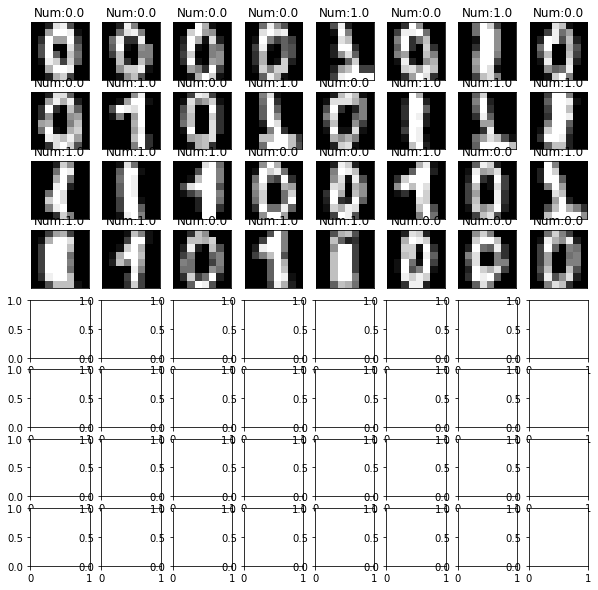

In [6]:
#show the first iteration batch
images, labels = next(iter(dataloader))
plt.figure()
f, axarr = plt.subplots(8,8, figsize=(10,10)) 
for i, ax in enumerate(axarr.ravel()):
    ax.imshow(images[i].reshape(8,8), cmap = 'gray')
    ax.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
    ax.set_title(f"Num:{labels[i]}")
f.tight_layout()
plt.show()

In [7]:
class Generator(nn.Module):

    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.dense_layer = nn.Linear(self.z_dim, 64)
        self.relu = nn.LeakyReLU()
        self.lin = nn.Linear(64, 64)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        x = self.dense_layer(x)
        x = self.relu(x)
        x = self.lin(x)
        x = self.activation(x)
        return x#self.activation(self.dense_layer(x))



(32, torch.Size([32, 64]))

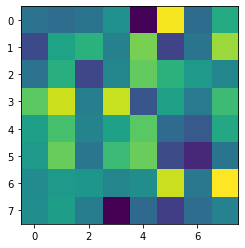

In [8]:
noise = torch.rand(batch_size, z_dim)

gen = Generator(z_dim)
plt.imshow(gen(noise)[0].view(8, 8).detach().numpy())
len(gen(noise)), gen(noise).shape

In [9]:
n_qubits = 5

@qml.qnode(qml.device("lightning.qubit", wires=n_qubits), interface="torch", diff_method="parameter-shift")
def quantum_generator_circuit(noise, gen_weights, gen_n_layers, n_qubits):

    gen_weights = gen_weights.reshape(gen_n_layers, n_qubits)

    # Encoding layer
    for i in range(n_qubits):
        qml.RY(noise[i], wires=i)

    #qml.AngleEmbedding(noise, wires=range(n_qubits))

    # PQC layers
    for i in range(gen_n_layers):

        # Rotation gates
        for y in range(n_qubits):
            #for w in range(n_gate_per_layer):
            #qml.RX(gen_weights[i][y], wires=y)  
            qml.RY(gen_weights[i][y], wires=y)   
            #qml.RZ(gen_weights[i][y], wires=y) 

    #RandomLayers(gen_weights, wires = list(range(n_qubits)), ratio_imprim = 0.1)
            
        # Entangling gates
        for y in range(n_qubits - 1):
            qml.CZ(wires=[y, y + 1])

    # Returning probability of each computational basis state
    return qml.probs(wires=list(range(n_qubits)))



class QuantumGenerator(nn.Module):

    def __init__(self, n_qubits, ancillary_qubits, gen_n_layers, n_generators, device, q_delta=1):
        super(QuantumGenerator, self).__init__()

        self.n_qubits = n_qubits
        self.ancillary_qubits = ancillary_qubits
        self.gen_n_layers = gen_n_layers
        #self.n_gate_per_layer = n_gate_per_layer
        self.n_generators = n_generators
        self.device = device
        self.vqc_params = nn.ParameterList([nn.Parameter(q_delta * torch.rand(self.gen_n_layers * self.n_qubits), 
                                          requires_grad=True)for _ in range(self.n_generators)])

    def forward(self, x):
        
        patch_size = 2 ** (self.n_qubits - self.ancillary_qubits)

        images = torch.Tensor(x.size(0), 0).to(self.device)

        # Iterate over all sub-generators
        for params in self.vqc_params:
            
            patches = torch.Tensor(0, patch_size).to(self.device)
            for elem in x:
                
                probs = quantum_generator_circuit(elem, params, self.gen_n_layers, self.n_qubits)
                partial_measure = probs[: (2 ** (n_qubits - self.ancillary_qubits))]
                partial_measure /= torch.sum(probs)
            
                out = partial_measure / torch.max(partial_measure)
                out = out.float().unsqueeze(0)
                patches = torch.cat((patches, out))

            # Building the image
            images = torch.cat((images, patches), 1)
            #print(images.shape)

        return images

(torch.Size([32, 5]),
 torch.Size([32, 64]),
 <matplotlib.image.AxesImage at 0x7f00ed0983d0>)

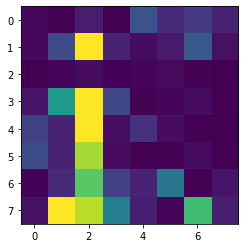

In [10]:
n_qubits = 5 
ancillary_qubits = 1
gen_n_layers = 3 
n_generators = 4 

qgen = QuantumGenerator(n_qubits = n_qubits, ancillary_qubits = ancillary_qubits, gen_n_layers = gen_n_layers, 
                        n_generators = n_generators, device = device)

noise = torch.rand(batch_size, 5)
noise.shape, qgen(noise).shape, plt.imshow(qgen(noise)[0].view(8, 8).detach().numpy())

In [11]:
class Discriminator(nn.Module):

    def __init__(self, image_size):
        super(Discriminator, self).__init__()

        self.image_size = image_size
        self.linear1 = nn.Linear(self.image_size * self.image_size, 64)
        self.relu1 = nn.LeakyReLU()
        #self.linear2 = nn.Linear(64, 16)
        #self.relu2 = nn.LeakyReLU()
        self.linear3 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        x = self.linear1(x)
        x = self.relu1(x)
        #x = self.linear2(x)
        #x = self.relu2(x)
        x = self.linear3(x)
        x = self.sigmoid(x)

        return x

In [12]:
real_data = digits[0]
torch.tensor(real_data).shape

disc = Discriminator(8)
#disc1(torch.tensor(real_data)).shape#, disc1(gen1(noise)).shape

In [13]:
class GAN():
    def __init__(self, model, dataloader, z_dim, batch_size, image_size, gen_net, disc_net, loss, lr_disc, lr_gen, device, save_path):

        self.model = model
        self.dataloader = dataloader
        self.z_dim = z_dim
        self.batch_size = batch_size
        self.image_size = image_size
        self.gen_net = gen_net
        self.disc_net = disc_net
        self.loss = loss
        self.lr_gen = lr_gen
        self.lr_disc = lr_disc
        self.gen_opt = Adam(self.gen_net.parameters(), self.lr_gen)
        self.disc_opt = Adam(self.disc_net.parameters(), self.lr_disc)
        self.device = device
        self.save_path = save_path

        self.ep_d_loss = []
        self.ep_g_loss = []
        

    def train_step(self, data):        
        
        #-------------- Discriminator training --------------#
        
        
        images = data.to(device)

        # Generating fake images
        noise = torch.randn(self.batch_size, self.z_dim)
        fake_images = self.gen_net(noise)

        self.disc_opt.zero_grad()
        real_preds = self.disc_net(images)
        real_targets = torch.ones(images.size(0), 1)
        # Passing fake images through discriminator
        fake_targets = torch.zeros(fake_images.size(0), 1)
        fake_preds = self.disc_net(fake_images)

        # Evaluating discriminator losses
        real_loss = self.loss(real_preds, real_targets)
        fake_loss = self.loss(fake_preds, fake_targets)   

        # Updating discriminator weights
        real_loss.backward()
        fake_loss.backward()
        d_loss = real_loss + fake_loss
        #print('disc loss: ', d_loss)
        self.disc_opt.step()


        #-------------- Generator training --------------#
        self.gen_opt.zero_grad()
    
        # Generating fake images
        latent = torch.randn(self.batch_size, self.z_dim)
        fake_images = self.gen_net(latent)

        #print('fake img: ', fake_images.shape)
        
        # Trying to fool the discriminator
        preds = self.disc_net(fake_images)
        targets = torch.ones(self.batch_size, 1)
        g_loss = self.loss(preds, targets)
        #print('gen loss after: ', g_loss)
        
        # Updating generator weights
        g_loss.backward()

        #print('gen loss before: ', g_loss)
        self.gen_opt.step()


        return g_loss, d_loss


    def learn(self, epochs):        

        self.fixed_noise = torch.rand(8, self.z_dim, device=self.device) #* math.pi / 2

        results = []

        epoch = 0

        with tqdm(range(epochs)) as tepochs:
       
            for epoch in tepochs:

                #print(f'Epoch {epoch}')
                for data, _ in dataloader:

                    d_losses = []
                    g_losses = []
                    
                    g_loss, d_loss = self.train_step(data)

                    # Keep losses for logging
                    d_losses.append(d_loss.item())
                    g_losses.append(g_loss.item())

                # Save average losses
                self.ep_d_loss.append(np.mean(d_losses))
                self.ep_g_loss.append(np.mean(g_losses))
                #tepochs.set_postfix({"Discriminator loss" : np.mean(d_losses), "Generator loss" : np.mean(g_losses)})

                # Saving models each 10 epochs
                if epoch % 10 == 0:

                    test_images = self.gen_net(self.fixed_noise).view(8,1,self.image_size,self.image_size).cpu().detach()
                    
                    if self.model == 'Classical_linear':
                        torch.save(self.gen_net, self.save_path + f'lin_gen_epoch_{epoch}')
                    elif self.model == 'Quantum_linear':
                        torch.save(self.gen_net, self.save_path + f'lin_q_gen_epoch_{epoch}')
                    elif self.model == 'Classical_convolutional':
                        torch.save(self.gen_net, self.save_path + f'conv_gen_epoch_{epoch}')
                    elif self.model == 'Quantum_convolutional':
                        torch.save(self.gen_net, self.save_path + f'conv_q_gen_epoch_{epoch}')
                    else:
                        print('Typology not admitted.')
                    
                    # Save results every 50 iterations
                    if epoch % 50 == 0:
                        results.append(test_images) 
                        torch.save(results, self.save_path + 'synthetic.pt')                                           
            

In [14]:
gan = GAN(model = 'Quantum_linear', dataloader = dataloader, z_dim = z_dim, batch_size = batch_size, image_size = 8, 
          gen_net = gen, disc_net = disc, loss = loss, lr_disc = lr_disc, lr_gen = lr_gen, device = device, save_path = save_path)

gan.learn(epochs)

100%|██████████| 1000/1000 [00:16<00:00, 60.29it/s]


<Figure size 432x288 with 0 Axes>

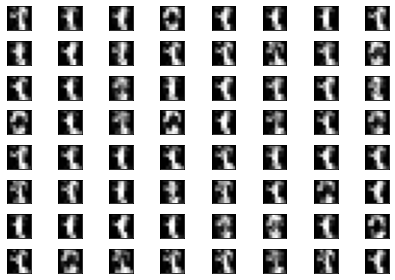

In [15]:
plt.figure()
f, axarr = plt.subplots(8,8) 
for i, ax in enumerate(axarr.ravel()):
    ax.imshow(gan.gen_net(torch.rand(z_dim)).detach().numpy().reshape(8,8), cmap = 'gray')
    ax.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
f.tight_layout()
plt.show()

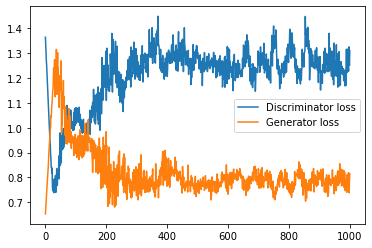

In [16]:
x = np.arange(epochs)
plt.plot(x, gan.ep_d_loss, label = "Discriminator loss")
plt.plot(x, gan.ep_g_loss, label = "Generator loss")
plt.legend()
plt.show()

In [ ]:
# def show_images(data, n_samples):

#     plt.figure(figsize=(8,2))

#     for i in range(n_samples):
#         image = data[i][0].reshape(8, 8)
#         plt.subplot(1,n_samples,i+1)
#         plt.axis('off')
#         plt.imshow(image.numpy(), cmap='gray')
        
#     plt.show()

In [ ]:
# gan.gen_net.eval()
# GAN_imgs = []

# fixed_noise = torch.rand(1, z_dim, dtype=torch.float64) 
# for i in range(len(digits)):      
     
#     image = gan.gen_net(fixed_noise).view(1,8,8).cpu().detach()
#     GAN_imgs.append(image)

# show_images(GAN_imgs, 8), GAN_imgs[0].shape

In [ ]:
# x = np.arange(len(gan.loss_g))
# plt.plot(x, gan.loss_d, label = "Discriminator loss")
# plt.plot(x, gan.loss_g, label = "Generator loss")
# plt.legend()
# plt.show()